# Issues of Adam on Complex number

env: tf 2.1

In [20]:
import tensorflow as tf
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from myadam import Adam

opt_gg  = tf.keras.optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.99, epsilon=1e-08, amsgrad=False)
opt_gcg =                     Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.99, epsilon=1e-08, amsgrad=False)

## A univariate cost function with no minimum on purpose to ease visualization

Cost function is $J = - x * conj(x)$, by using rules from Wirtinger calculus we have $\nabla J = \frac{\partial J}{\partial x^*}=-x$, **thus the steepest descent direction is $x$**

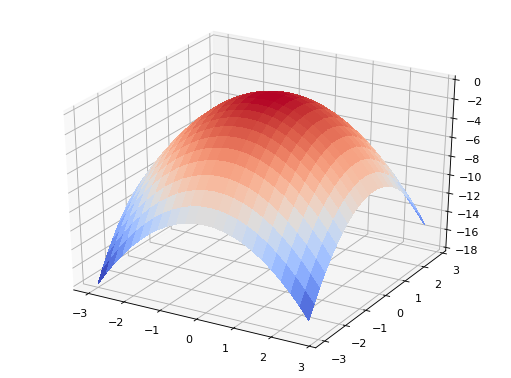

In [21]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80)
ax = fig.gca(projection='3d')
# Make data.
re = np.arange(-3, 3, 0.25)
im = np.arange(-3, 3, 0.25)
re, im = np.meshgrid(re, im)
J = -(re**2 + im**2)
surf = ax.plot_surface(re, im, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

## Optimize

In [22]:
init_x = 1.+1.j # x starts from here

costfun = lambda z: -tf.math.abs(z)**2 # cost function

with tf.device('/CPU:0'):
    x = tf.Variable(init_x)

def optimize(opt, steps=100):
    trace_x = []
    for _ in range(steps):
        with tf.GradientTape() as tape:
            cost = costfun(x)
        grads = tape.gradient(cost , [x])
        opt.apply_gradients( zip( grads , [x] ) )
        trace_x = np.append(trace_x, x.numpy())
    return trace_x

tr_x_gg  = optimize(opt_gg)
final_x_gg  = x.numpy()
tf.print('final_x_gg  = ', final_x_gg)

x.assign(init_x) # reset x

tr_x_gcg = optimize(opt_gcg)
final_x_gcg = x.numpy()
tf.print('final_x_gcg = ', final_x_gcg)

final_x_gg  =  (2.0687643912074583+0.9514396793989471j)
final_x_gcg =  (1.7631966603488112+1.7631966603488112j)


## Check the traces of x variable

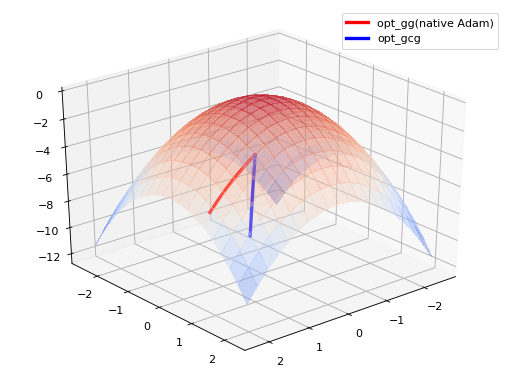

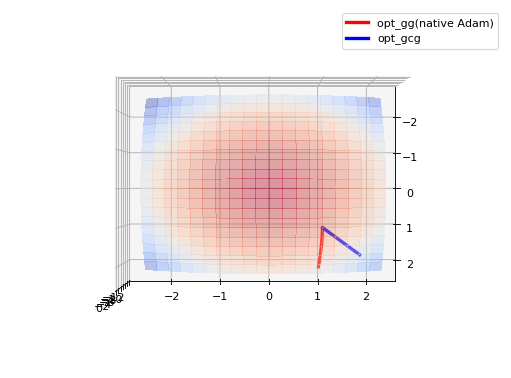

In [23]:
def check_trace(elev=30, azim=50):
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80)
    ax = fig.gca(projection='3d')
    # Make data.
    re = np.arange(-2.5, 2.5, 0.25)
    im = np.arange(-2.5, 2.5, 0.25)
    re, im = np.meshgrid(re, im)
    J = -(re**2 + im**2)
    surf = ax.plot_surface(re, im, J, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.4)
    ax.plot3D(np.real(tr_x_gg),np.imag(tr_x_gg),costfun(tr_x_gg).numpy(), 'r', linewidth=3);
    ax.plot3D(np.real(tr_x_gcg),np.imag(tr_x_gcg),costfun(tr_x_gcg).numpy(), 'b', linewidth=3);
    ax.view_init(elev, azim)
    ax.legend(["opt_gg(native Adam)", "opt_gcg"])
    plt.show()
    
check_trace()
check_trace(90, 0)

## Translate the above problem to its real-value counterpart

In [24]:
init_xr = np.real(init_x)
init_xi = np.imag(init_x)

costfun_realval = lambda re,im: -(re**2+im**2) # cost function

with tf.device('/CPU:0'):
    xr = tf.Variable(init_xr)
    xi = tf.Variable(init_xi)

def optimize_realval(opt, steps=100):
    trace_xr = []
    trace_xi = []
    for _ in range(steps):
        with tf.GradientTape() as tape:
            cost = costfun_realval(xr,xi)
        grads = tape.gradient(cost , [xr,xi])
        opt.apply_gradients( zip( grads , [xr,xi] ) )
        trace_xr = np.append(trace_xr, xr.numpy())
        trace_xi = np.append(trace_xi, xi.numpy())
    return trace_xr,trace_xi

tr_xr_gg,tr_xi_gg  = optimize_realval(opt_gg)
final_xr_gg  = xr.numpy()
final_xi_gg  = xi.numpy()
tf.print('final_x_gg_realval  = ', np.complex(final_xr_gg, final_xi_gg))

final_x_gg_realval  =  (2.581552743911743+2.581552743911743j)


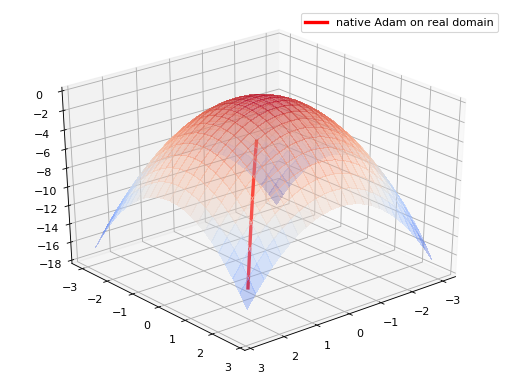

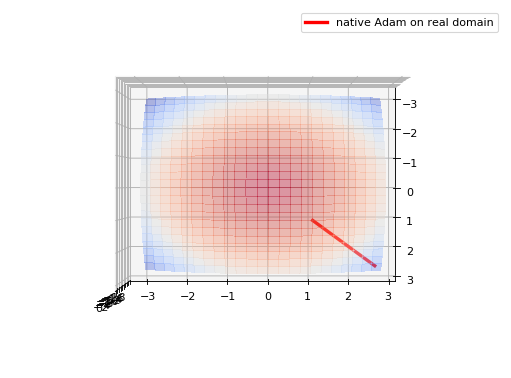

In [25]:
def check_trace_realval(elev=30, azim=50):
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80)
    ax = fig.gca(projection='3d')
    # Make data.
    re = np.arange(-3, 3, 0.25)
    im = np.arange(-3, 3, 0.25)
    re, im = np.meshgrid(re, im)
    J = -(re**2 + im**2)
    surf = ax.plot_surface(re, im, J, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.4)
    ax.plot3D(tr_xr_gg,tr_xi_gg,costfun_realval(tr_xr_gg,tr_xi_gg), 'r', linewidth=3);
    ax.view_init(elev, azim)
    ax.legend(["native Adam on real domain"])
    plt.show()
    
check_trace_realval()
check_trace_realval(90, 0)

## Amsgrad

In [26]:
opt_gg.amsgrad  = True
opt_gcg.amsgrad = True

In [27]:
tr_x_gg  = optimize(opt_gg)
final_x_gg  = x.numpy()
tf.print('final_x_gg  = ', final_x_gg)

NotFoundError: No registered 'ResourceApplyAdamWithAmsgrad' OpKernel for 'CPU' devices compatible with node {{node ResourceApplyAdamWithAmsgrad}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_COMPLEX128, use_locking=true
	.  Registered:  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_HALF]
 [Op:ResourceApplyAdamWithAmsgrad]

In [28]:
tr_x_gcg  = optimize(opt_gcg)
final_x_gcg  = x.numpy()
tf.print('final_x_gcg  = ', final_x_gcg)

final_x_gcg  =  (2.6113513641189865+2.6113513641189865j)
